In [ ]:
# Battery data accessible from 
# https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/ 
# The dataset has 4 batteries and multiple charge-discharge cycles, however only 1 discharge cycle is considered

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
import math

In [2]:
dict_set = loadmat('B0005.mat')
list(dict_set.keys())

['__header__', '__version__', '__globals__', 'B0005']

In [3]:
heads = dict_set['B0005'][0][0][0][0]

In [4]:

for cycle,i in enumerate(heads):
    operation = i[0][0]
    if operation == 'discharge':
        data = i[3]
        voltage_measured = np.array(data[0][0][0][0])
        current_measured = np.array(data[0][0][1][0])
        temperature_measured = np.array(data[0][0][2][0])
        time_vector = np.array(data[0][0][5][0])
        capacity = np.array(data[0][0][6][0])

print(capacity)
current_measured = current_measured*-1

[1.32507933]


Text(0.5, 1.0, 'Measured Voltage vs Time')

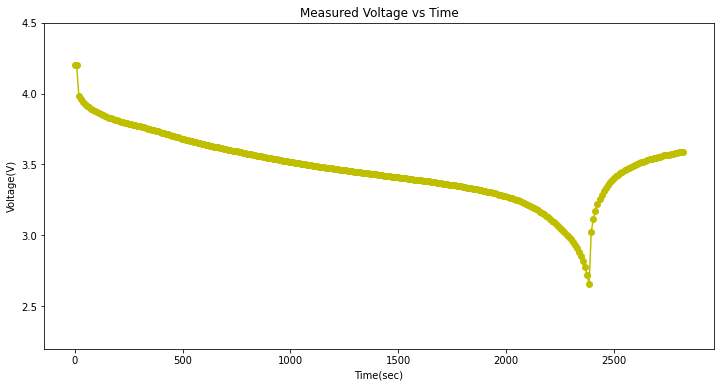

In [5]:
plt.figure(figsize=(12,6))
plt.plot(time_vector,voltage_measured,'-o',c='y')
plt.ylim(2.2,4.5)
plt.xlabel("Time(sec)")
plt.ylabel("Voltage(V)")
plt.title("Measured Voltage vs Time")

Text(0.5, 1.0, 'Measured Current vs Time')

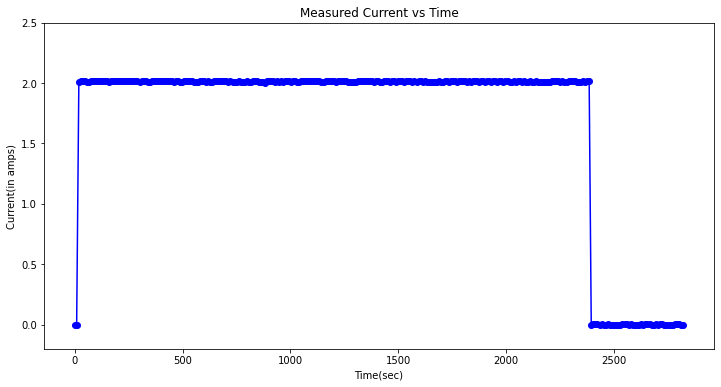

In [6]:
plt.figure(figsize=(12,6))
plt.plot(time_vector,current_measured,'-o',c='b')
plt.ylim(-0.2,2.5)
plt.xlabel("Time(sec)")
plt.ylabel("Current(in amps)")
plt.title("Measured Current vs Time")

Text(0.5, 1.0, 'Measured Temperature vs Time')

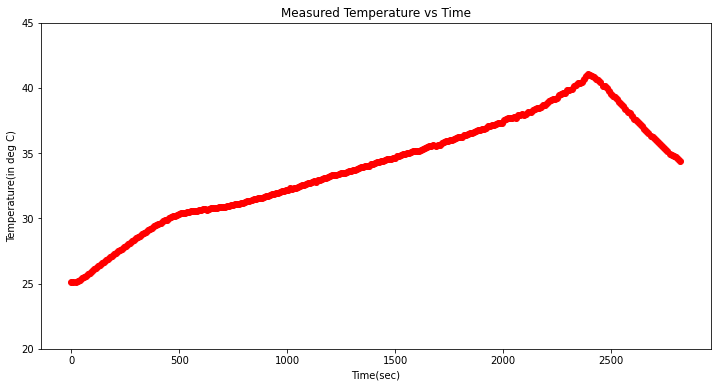

In [7]:
plt.figure(figsize=(12,6))
plt.plot(time_vector,temperature_measured,'-o',c='r')
plt.ylim(20,45)
plt.xlabel("Time(sec)")
plt.ylabel("Temperature(in deg C)")
plt.title("Measured Temperature vs Time")

In [8]:
# Battery parameter estimation

In [9]:
min_v_index = np.argmin(voltage_measured)
del_V_inst = voltage_measured[min_v_index+1] - voltage_measured[min_v_index]
del_I = current_measured[min_v_index] - current_measured[min_v_index+1]
R0 = del_V_inst/del_I
del_V_inf = voltage_measured[voltage_measured.size-1]-voltage_measured[min_v_index]
R1 = del_V_inf/del_I - R0
print(R0,R1)

0.18445968308503957 0.2800096565672116


In [10]:
t1 = time_vector[min_v_index+1]
vconst = voltage_measured[min_v_index+1] + (0.993*del_V_inf)
t2 = time_vector.size - 1
while(voltage_measured[t2] > vconst):
    t2 = t2 - 1
del_T = time_vector[t2] - t1
C1 = del_T/(5*R1)
print(C1,del_T)

304.85520051880843 426.8119999999999


In [11]:
for cycle,i in enumerate(heads):
    operation = i[0][0]
    if operation == 'charge':
        data = i[3]
        v_m = np.array(data[0][0][0][0])
        #current_measured = np.array(data[0][0][1][0])
        #temperature_measured = np.array(data[0][0][2][0])
        #time_vector = np.array(data[0][0][5][0])
        #capacity = np.array(data[0][0][6][0])
ocv = np.zeros(1001)
ocv[0] = 2.7
ocv[1000] = v_m[4]
slope = (ocv[1000]-ocv[0])/1001
for i in range(1000):
    ocv[i] = ocv[0] + slope*i
print(slope)

0.00151192775624425


In [12]:
#Kalman filter implementation
X = np.array([[0.0],[1.0]])  # State variable : [[Vcapacitor],[SOC]]
U = np.array([[0.0],[25.0]])  # Input variables : [[i],[temp diff]]
P = np.diag([1,1])
K = np.array([[0.0],[0.0]])
ak = np.array([[0.9757691089747373,0],[0,1]])
bk = np.array([[-0.006784883474301327,0],[0,0]])
ck = np.array([[-1,slope]])
dk = np.array([-R0,0.05])
Qk = np.eye(2)
Err = np.array([0])
Rk = np.array([0.5])
v_pred = np.zeros(time_vector.size) # Voltage Predicted
soc = np.zeros(time_vector.size)
v_pred[0] = 4.25
soc[0] = 100
i = 1
while i < time_vector.size:
    U[0][0] = current_measured[i-1]
    U[1][0] = temperature_measured[i-1]-25
    time_diff = time_vector[i]-time_vector[i-1]
    ak[0][0] = math.exp(-time_diff/del_T)
    bk[0][0] = (1 - math.exp(-time_diff/del_T))*R1
    bk[1][0] = -time_diff/(capacity*3600)
    
    #Prediction step
    X = np.dot(ak,X) + np.dot(bk,U)
    t = X[1][0]
    P = np.dot(ak,np.dot(P,np.transpose(ak))) + Qk
    v_pred[i] = ocv[int(X[1][0]*1000)] - X[0][0] + np.dot(dk,U)#np.dot(ck,X)

    #Update step
    Err = voltage_measured[i] - v_pred[i]
    temp = float(np.dot(ck,np.dot(P,np.transpose(ck))) + Rk)
    K = np.dot(P,np.transpose(ck))/temp
    K = np.reshape(K,(2,1))
    X = X + Err*K
    ck = np.reshape(ck,(1,2))
    P = np.dot((np.array([[1.0,0],[0,1.0]])-np.dot(K,ck)),P)
    
    soc[i] = X[1][0]*100
    #print(soc[i])
    i = i+1
    

In [13]:
# Theoretical Calculations
# Average Ahr discharged = I x time 
theo_soc = np.zeros(time_vector.size)
theo_soc[0] = 1
Q_total = capacity*3600
for i in range(1,time_vector.size-1):
    theo_soc[i] = theo_soc[i-1] - (time_vector[i] - time_vector[i-1])*(current_measured[i])/(Q_total)

theo_soc = 100*theo_soc

(2.0, 4.5)

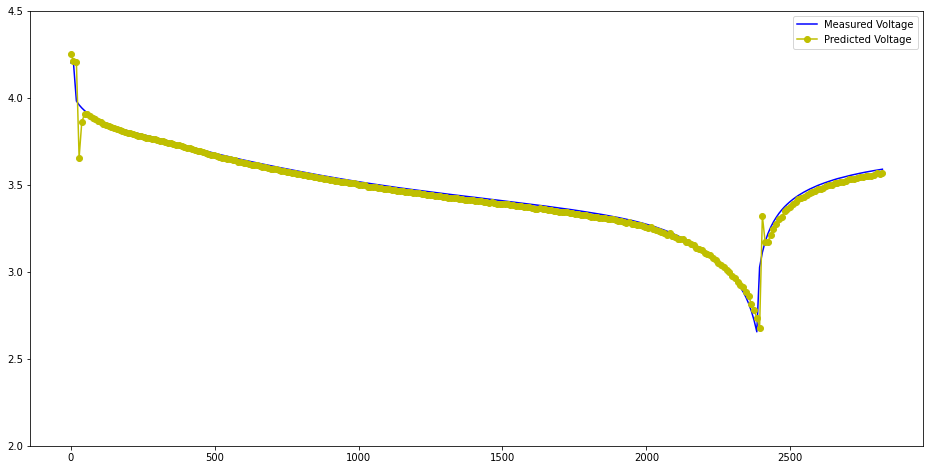

In [14]:
plt.figure(figsize=(16,8))
plt.plot(time_vector,voltage_measured,c='b',label='Measured Voltage')
plt.plot(time_vector,v_pred,'-o',c='y',label='Predicted Voltage')
plt.legend()
plt.ylim(2,4.5)

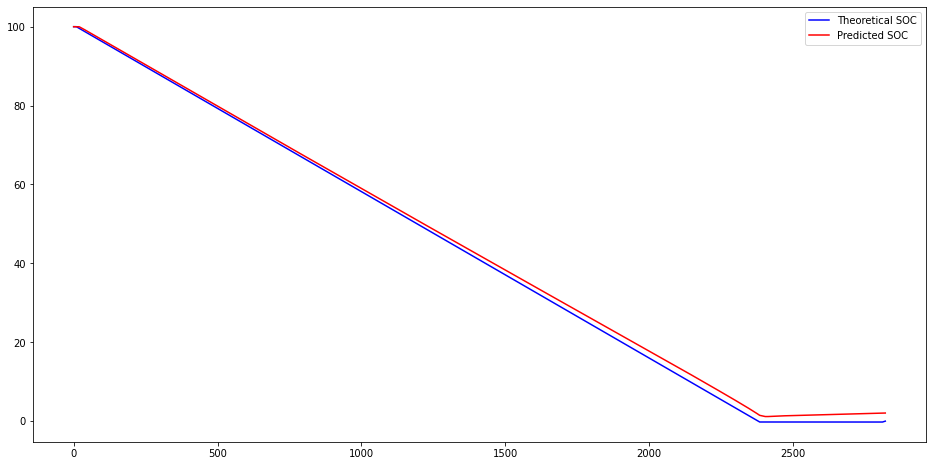

In [15]:
plt.figure(figsize=(16,8))
plt.plot(time_vector,theo_soc,c='b',label='Theoretical SOC')
plt.plot(time_vector,soc,'-r',label='Predicted SOC')
plt.legend()